In [19]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.svm import OneClassSVM

%matplotlib inline

In [24]:
columns= ["duration", "protocol type", "service", "flag", "src bytes", "dst bytes", "land", "wrong fragment", "urgent", "hot", "num failed logins", "logged in", "num compromised", "root shell", "su attempted", "num root", "num file creations", "num shells", "num access files", "num outbound cmds", "is host login", "is guest login", "count", "srv count", "serror rate", "srv serror rate", "rerror rate", "srv rerror rate", "same srv rate", "diff srv rate", "srv diff host rate", "dst host count", "dst host srv count", "dst host same srv rate", "dst host diff srv rate", "dst host same src port rate", "dst host srv diff host rate", "dst host serror rate", "dst host srv serror rate", "dst host rerror rate", "dst host srv rerror rate", "label"] 
df = pd. read_csv ("kddcup.data.corrected", sep="," , names=columns, index_col=None)

In [25]:
df = df[df["service"] == "http"]
df = df.drop("service", axis=1)
columns.remove("service")

novelties = df[df["label"] != "normal."] #비정상 데이터 (지정하지 않았지만 총 4,045개)
novelties_normal = df[150000:154045] #임의 데이터 4,045개

novelties = pd.concat([novelties, novelties_normal]) #비정상 데이터 + 임의 데이터 4,045개
normal = df[df["label"] == "normal."] #정상 데이터

In [33]:
for col in normal.columns:
    if normal[col].dtype == "object":
        encoded = LabelEncoder()
        encoded.fit(normal[col])
        normal[col] = encoded.transform(normal[col])

for col in novelties.columns:
    if novelties[col].dtype == "object":
        encoded = LabelEncoder()
        encoded.fit(novelties[col])
        novelties[col] = encoded.transform(novelties[col])


스트링 라벨 인코딩 

In [36]:
for f in range(0,10):
    normal = normal.iloc[np.random.permutation(len(normal))]

df2 = pd.concat([normal[:100000], normal[200000:250000]]) #정상 데이터 150,000개 for train
df_validate = normal[100000:150000] #정상 데이터 50,000개 for validate
x_train, x_test = train_test_split(df2, test_size=0.2, random_state=42) #150,000개 중 80%는 train, 20%는 test
x_val = df_validate

In [42]:
ocsvm = OneClassSVM(kernel='rbf', gamma=0.00005, nu = 0.1) 

Radial Basis Function 커널 사용, 커널 폭 0.00005(작을 수록 결정 경계가 부드러움), nu = 0.1 은 이상치 비율 

In [43]:
ocsvm.fit(x_train)

OneClassSVM(gamma=5e-05, nu=0.1)

In [44]:
preds = ocsvm.predict(x_test)
score = 0
for f in range(0,x_test.shape[0]):
    if(preds[f] == 1):
        score = score + 1

accuracy = score / x_test.shape[0]
print("Accuracy: {:.2%}".format(accuracy))

Accuracy: 89.79%


In [45]:
preds = ocsvm.predict(x_val)
score = 0
for f in range(0,x_val.shape[0]):
    if(preds[f] == 1):
        score = score + 1

accuracy = score / x_val.shape[0]
print("Accuracy: {:.2%}".format(accuracy))

Accuracy: 89.67%


위 코드 부분은 정상 데이터만으로 예측했기 때문에 AUC는 알 수 없다

In [46]:
from sklearn.metrics import roc_auc_score

preds = ocsvm.predict(novelties)
matches = novelties["label"] == 4

auc = roc_auc_score(preds, matches)
print("AUC:     {:.2%}".format(auc))

AUC:     95.85%


novelties 데이터는 정상, 이상 데이터가 각각 반반이므로 AUC 계산이 가능하다.

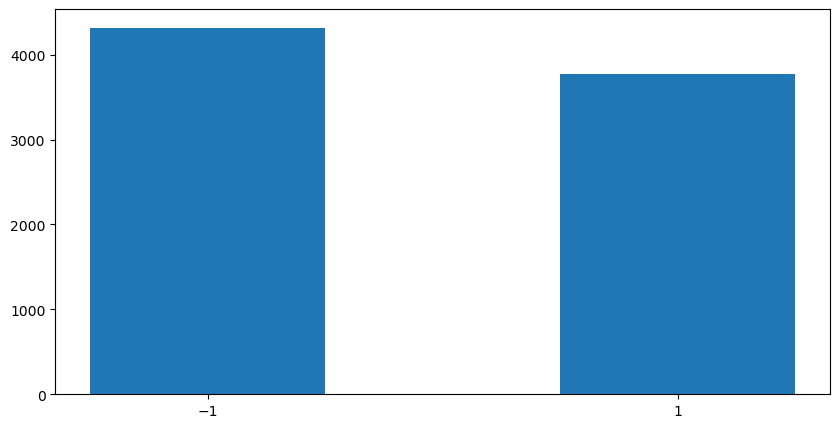

In [47]:
plt.figure(figsize=(10,5))
plt.hist(preds, bins=[-1.5,-0.5] + [0.5,1.5],align='mid')
plt.xticks([-1,1])
plt.show()